# **Sentence Reconstruction** 
## Deep Learning Exam, 10/06/2023
## Daniele Napolitano
#### daniele.napolitano4@studio.unibo.it - 0001085649


---



The purpose of this project is to take in input a sequence of words corresponding to a random permutation of a given english sentence, and reconstruct the original sentence. 
CONSTRAINTS:
* No pretrained model can be used.
* The neural network models should have less the 20M parameters.

In this work, I propose a Transformer model for the task of sentence shuffling, which can generate shuffled sentences that preserve the meaning and grammaticality of the original sentences. I compare the performance of the proposed Transformer model with other alternative methods that use Seq2Seq models or positional vectors.

# Dataset

The dataset is composed by a snapshot of wikipedia. We restricted the vocabolary to the 10K most frequent words, and only took sentences making use of this vocabulary. In addition, we restricted to sequences with a length between 3 and 30 words.

In [ ]:
!pip install datasets
!pip3 install apache-beam
!pip install -q --upgrade keras-nlp tensorflow


In [2]:
from random import Random
randomizer = Random(42)

In [4]:
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical, pad_sequences
import numpy as np 
import pickle
import gdown
import random

In [5]:
from datasets import load_dataset
dataset = load_dataset("wikipedia", "20220301.simple")
data = dataset['train'][:20000]['text']

Downloading:   0%|          | 0.00/1.66k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/235M [00:00<?, ?B/s]

Dataset wikipedia downloaded and prepared to /root/.cache/huggingface/datasets/wikipedia/20220301.simple/2.0.0/aa542ed919df55cc5d3347f42dd4521d05ca68751f50dbc32bae2a7f1e167559. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [6]:
#run this cell only the first time to create and save the tokenizer and the date
dump = True
tokenizer = Tokenizer(split=' ', filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n', num_words=10000, oov_token='<unk>')
corpus = []
# Split of each piece of text into sentences
for elem in data:
  corpus += elem.lower().replace("\n", "").split(".")[:]
print("corpus dim: ",len(corpus))
#add a start and an end token
corpus = ['<start> '+s+' <end>' for s in corpus]
# Tokenization	
tokenizer.fit_on_texts(corpus)
if dump:
    with open('tokenizer.pickle', 'wb') as handle:
        pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
original_data = [sen for sen in tokenizer.texts_to_sequences(corpus) if (len(sen) <= 32 and len(sen)>4 and not(1 in sen))]
if dump:
    with open('original.pickle', 'wb') as handle:
        pickle.dump(original_data, handle, protocol=pickle.HIGHEST_PROTOCOL)
print ("filtered sentences: ",len(original_data))

sos = tokenizer.word_index['<start>']
eos = tokenizer.word_index['<end>']
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

corpus dim:  510023
filtered sentences:  137301


In [7]:
print(len(tokenizer.word_index)) #this dictionary maps integers to words. its size is the number of unique tokens
vocabulary_dim = tokenizer.num_words
print(vocabulary_dim)

271573
10000


* shuffled_data contains scrumbled sequences, and will be the input to the model. 
* target_data is the same as original data but offset by one timestep.
It is only useful if you plan to do some language modeling with a teacher forcing technique. You might decide to ignore it.


In [8]:
shuffled_data = [random.sample(s[1:-1],len(s)-2) for s in original_data]
shuffled_data = [[sos]+s+[eos] for s in shuffled_data]
target_data = [s[1:] for s in original_data] #it's original data without sos token

In [9]:
from sklearn.model_selection import train_test_split
x_train, x_test, c_train, c_test, y_train, y_test = train_test_split(original_data, shuffled_data, target_data, test_size = 0.3, random_state = 42)

In [10]:
max_sequence_len = max([len(x) for x in original_data])
#pad everything
x_train = pad_sequences(x_train, maxlen=max_sequence_len, padding='post')
x_test = pad_sequences(x_test, maxlen=max_sequence_len, padding='post')
c_train = pad_sequences(c_train, maxlen=max_sequence_len, padding='post')
c_test = pad_sequences(c_test, maxlen=max_sequence_len, padding='post')
y_train = pad_sequences(y_train, maxlen=max_sequence_len, padding='post')
y_test = pad_sequences(y_test, maxlen=max_sequence_len, padding='post')
#create padding masks
x_train_mask = np.where(x_train == 0, 0, 1)
x_test_mask = np.where(x_test == 0, 0, 1)
c_train_mask = np.where(c_train == 0, 0, 1)
c_test_mask = np.where(c_test == 0, 0, 1)

In [11]:
print("x_train size:", len(x_train))
assert(len(x_train)==len(c_train)==len(y_train))

x_train size: 96110


# Metrics

The quality of the results will be measured according to the following metric:

1.  look for the longest substring w between s and p
2.  compute |w|/max(|s|,|p|)

If the match is exact, the score is 1. 




In [14]:
from difflib import SequenceMatcher
def score(s,p):
  match = SequenceMatcher(None, s, p).find_longest_match()
  #print(match.size)
  return (match.size/max(len(p),len(s)))  

# The model (Transformer)
For this task, it was implemented a Transformer model, following as much as possible the implementation described in the original paper _["Attention is all you need"](https://arxiv.org/pdf/1706.03762.pdf) (Vaswani et al., 2017)_.<br>
### Hyperparameters
Here are some of the most important hyperparameters and their meaning:
- `embedding dim` -> **256** (The dimensionality of the model's hidden states and embeddings)
- `num_heads` -> **10** (The number of attention heads used in the multi-head attention mechanism)
- `num_layers` -> **5** (The number of layers in the encoder and decoder stacks)
- `intermediate_dim` -> **1640** (The number of units in the feedforward sublayer of the encoder and decoder layers)
- `dropout_rate` -> **0.1** (The dropout rate used in the encoder and decoder layers)
- `batch_size` -> **512** (The number of samples processed in each training batch)
- `optimizer` -> **Adam**, with the same parameters of the paper (The optimizer used to train the model)
- `learning_rate` -> The learning rate followed a custom schedule, taken by the original paper
- `warmup_steps` -> **1000** (The number of warmup steps used in the learning rate schedule)


In [15]:
from keras_nlp.models import AlbertBackbone
from keras_nlp.layers import TransformerEncoder, TokenAndPositionEmbedding, TransformerDecoder

from keras.layers import Dense, Input, Reshape, Dropout
from keras.models import Model
from tensorflow.keras.optimizers import Adam

def get_transformer(embedding_dim, num_enc_layers, num_dec_layers, intermediate_dim, num_heads):

  #============== INPUTS ===================
  enc_id_input = Input(
      shape=(32,),
      dtype="int32",
      name="token_ids_enc",
  )
  dec_id_input = Input(
      shape=(32,),
      dtype="int32",
      name="token_ids_dec",
  )
  #padding masks are useful for the model to only focus on the relevant parts, and to be more efficient
  padding_mask_enc = Input( shape=(32,), name="padding_mask_enc",)
  padding_mask_dec = Input( shape=(32,),name="padding_mask_dec",)

  #============== ENCODER ==================
  emb_enc = TokenAndPositionEmbedding(
      vocabulary_size=10000,
      sequence_length=32,
      embedding_dim=embedding_dim,
      name="enc_emb",
  )(enc_id_input)
  #create list of encoders
  encoder_layers = []
  for i in range(num_enc_layers):
    encoder_layer = TransformerEncoder(
      num_heads=num_heads,
      intermediate_dim=intermediate_dim,
      dropout=0.1,
      name="encoder"+str(i)
    )
    encoder_layers.append(encoder_layer)
  # Apply encoder layers
  encoder_seq = emb_enc
  for encoder_layer in encoder_layers:
    encoder_seq = encoder_layer(encoder_seq, padding_mask=padding_mask_enc)

  #============== DECODER ==================
  emb_dec = TokenAndPositionEmbedding(
      vocabulary_size=10000,
      sequence_length=32,
      embedding_dim=embedding_dim,
      name="dec_emb",
  )(dec_id_input)
  # Create a list of decoder layers
  decoder_layers = []
  for i in range(num_dec_layers):
    decoder_layer = TransformerDecoder(
      num_heads=num_heads,
      intermediate_dim=intermediate_dim,
      dropout=0.1,
      name="decoder"+str(i)
    )
    decoder_layers.append(decoder_layer)
  # Apply decoder layers
  decoder_seq = emb_dec
  for decoder_layer in decoder_layers:
    decoder_seq = decoder_layer(encoder_sequence=encoder_seq, decoder_sequence=decoder_seq,
                                decoder_padding_mask=padding_mask_dec, encoder_padding_mask=padding_mask_enc)
    
  #================ OUTPUT ================
  outputs = Dense(10000, activation="softmax")(decoder_seq)

  model = Model(inputs=[enc_id_input,dec_id_input, padding_mask_enc, padding_mask_dec], outputs=outputs)
  model.summary()
  return model

In [32]:
import tensorflow as tf
# custom learning rate schedule used in the original Transformer paper
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super().__init__()
    self.d_model = d_model
    self.warmup_steps = warmup_steps
  def __call__(self, step):
    step = tf.cast(step, dtype=tf.float32)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * tf.cast((self.warmup_steps ** -1.5), dtype=tf.float32)
    return tf.math.rsqrt(tf.cast(self.d_model, dtype=tf.float32)) * tf.math.minimum(arg1, arg2)
  def get_config(self):
    config = {
        'd_model': self.d_model,
        'warmup_steps': self.warmup_steps
    }
    return config
  
embedding_dim=256
learning_rate = CustomSchedule(d_model=embedding_dim, warmup_steps=1000)

model=get_transformer(embedding_dim=embedding_dim, num_enc_layers=5, num_dec_layers=5, intermediate_dim=1640, num_heads=10)
optimizer=Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.98,epsilon=1e-9) # same optimizer params as original Transformer paper
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["categorical_accuracy"])

Model: "model_14"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 token_ids_enc (InputLayer)     [(None, 32)]         0           []                               
                                                                                                  
 padding_mask_enc (InputLayer)  [(None, 32)]         0           []                               
                                                                                                  
 enc_emb (TokenAndPositionEmbed  (None, 32, 256)     2568192     ['token_ids_enc[0][0]']          
 ding)                                                                                            
                                                                                                  
 encoder0 (TransformerEncoder)  (None, 32, 256)      1099606     ['enc_emb[0][0]',         

# Training

The snippet below defines a generator function that creates one-hot encodings of the output sequences and shuffles the tokens in the input sequences, so for each batch it will see a new way of shuffling the data (to reduce overfitting and to better generalize). <br>
The generator will be fed to the `fit` method, and returns a tuple of input and output sequences for each batch.<br>
There are also two callback functions for early stopping and checkpointing the best model.



In [33]:
def generator(x_train, c_train, pad_mask, y_train, batch_size):
    while True:
        for i in range(0, len(x_train), batch_size):
            y_onehot = to_categorical(y_train[i:i+batch_size], num_classes=vocabulary_dim)
            #create new c_train by shuffling the tokens in x_train[i:i+batch_size] (apart from first token, eos token and padding tokens)
            target=c_train[i:i+batch_size]
            for j in range(len(target)):
                eos_index=np.where(target[j]==eos)[0][0]
                target[j][1:eos_index]=np.random.permutation(target[j][1:eos_index])
            yield ([target,x_train[i:i+batch_size], pad_mask[i:i+batch_size], pad_mask[i:i+batch_size]], y_onehot)

#callbacks
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1) #stop if validation loss does not improve for 5 epochs
checkpoint_all = ModelCheckpoint('checkpoint_{epoch:02d}.h5',verbose=0)

In [34]:
batch_size=512
history=model.fit(generator(x_train, c_train, c_train_mask, y_train, batch_size=batch_size), steps_per_epoch=len(x_train)//batch_size, epochs=100, shuffle=True, 
          validation_data=generator(x_test, c_test, c_test_mask,y_test, batch_size), validation_steps=5, 
          callbacks=[ checkpoint_all, early_stopping])

Epoch 1/100
187/187 [==============================] - 299s 1s/step - loss: 4.8360 - categorical_accuracy: 0.5788 - val_loss: 2.5200 - val_categorical_accuracy: 0.6674
Epoch 2/100
187/187 [==============================] - 219s 1s/step - loss: 2.2933 - categorical_accuracy: 0.6806 - val_loss: 2.2371 - val_categorical_accuracy: 0.6767
Epoch 3/100
187/187 [==============================] - 212s 1s/step - loss: 1.9855 - categorical_accuracy: 0.7038 - val_loss: 1.8637 - val_categorical_accuracy: 0.7156
Epoch 4/100
187/187 [==============================] - 216s 1s/step - loss: 1.6879 - categorical_accuracy: 0.7342 - val_loss: 1.4962 - val_categorical_accuracy: 0.7627
Epoch 5/100
187/187 [==============================] - 215s 1s/step - loss: 1.1898 - categorical_accuracy: 0.7989 - val_loss: 0.9563 - val_categorical_accuracy: 0.8328
Epoch 6/100
187/187 [==============================] - 219s 1s/step - loss: 0.7571 - categorical_accuracy: 0.8539 - val_loss: 0.6948 - val_categorical_accuracy:

### Fine tuning
The model will be fine-tuned for a couple of batches, using a smaller learning rate of 5e-5. <br>
This will slightly improve the final performance of the model (by adding around 0.025 to the final score).

In [35]:
finetune_stopping = EarlyStopping(monitor='val_categorical_accuracy', patience=3, verbose=1) 
optimizer=Adam(learning_rate=5e-5, beta_1=0.9, beta_2=0.98,epsilon=1e-9) #fixed learning rate
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["categorical_accuracy"])

batch_size=512
finetune_history=model.fit(generator(x_train, c_train, c_train_mask, y_train, batch_size=batch_size), steps_per_epoch=len(x_train)//batch_size, epochs=2, shuffle=True, 
          validation_data=generator(x_test, c_test, c_test_mask,y_test, batch_size), validation_steps=5, 
          callbacks=[finetune_stopping])
model.save("transformer256Emb_finetuned.h5")

Epoch 1/2
187/187 [==============================] - 288s 1s/step - loss: 0.1071 - categorical_accuracy: 0.9662 - val_loss: 0.5635 - val_categorical_accuracy: 0.9015
Epoch 2/2
187/187 [==============================] - 216s 1s/step - loss: 0.0856 - categorical_accuracy: 0.9725 - val_loss: 0.5683 - val_categorical_accuracy: 0.8987


In [37]:
#save model and training history as csv file
import pandas as pd
hist_df = pd.DataFrame(history.history)
hist_csv_file = 'history_transformer256Emb.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

## Analysis of training history
The training history is shown below in graphs showing loss and accuracy on the training and validation sets. <br>
Also, the learning rate schedule is shown with respect to the number of steps.

total steps:  7168
total epochs:  14


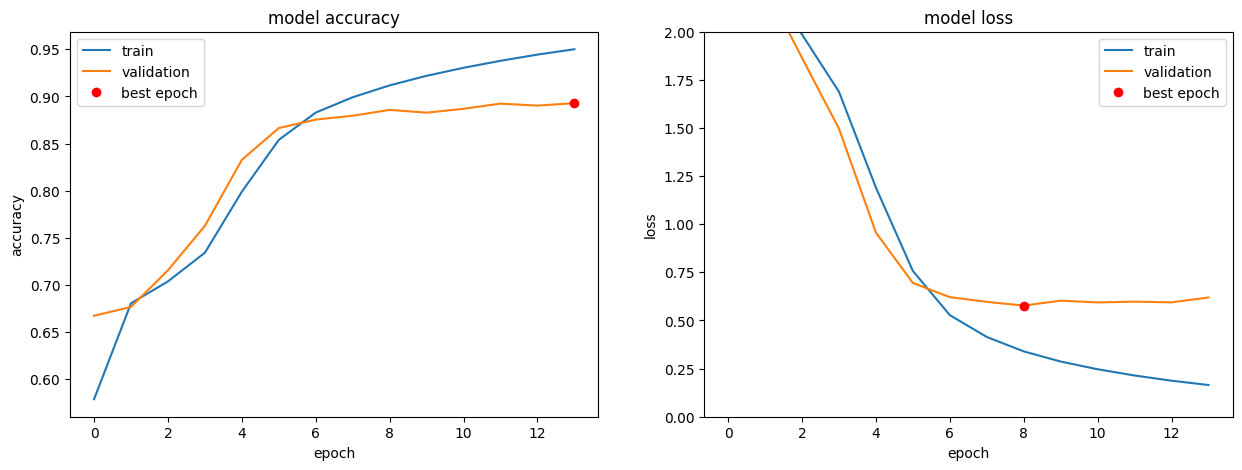

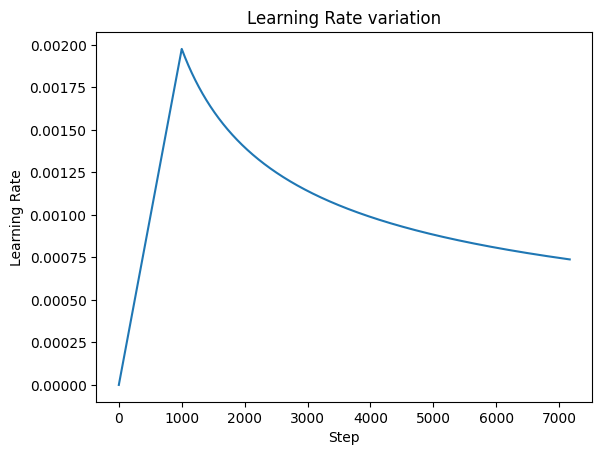

In [38]:
#print number of steps and epochs done
print("total steps: ", len(history.history["loss"])*batch_size)
print("total epochs: ", len(history.history["loss"]))
#plot accuracy
import matplotlib.pyplot as plt
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(history.history['categorical_accuracy'], label="train")
plt.plot(history.history['val_categorical_accuracy'], label="validation")
#draw a red point at the best epoch for validation accuracy
best_epoch=np.argmax(history.history['val_categorical_accuracy'])
plt.plot(best_epoch,history.history['val_categorical_accuracy'][best_epoch],'ro', label="best epoch")
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
#plot loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label="train")
plt.plot(history.history['val_loss'], label="validation")
#draw a red point at the best epoch for validation loss
best_epoch=np.argmin(history.history['val_loss'])
plt.plot(best_epoch,history.history['val_loss'][best_epoch],'ro', label="best epoch")
plt.title('model loss')
plt.ylabel('loss')
plt.ylim([0, 2])  # Set y-axis limits to [0, 2]
plt.xlabel('epoch')
plt.legend()
plt.show()
#plot learning rate
learning_rates = [learning_rate(step).numpy() for step in range(len(history.history['loss'])*batch_size)]
plt.plot(np.arange(len(learning_rates)), learning_rates)
plt.title("Learning Rate variation")
plt.xlabel("Step")
plt.ylabel("Learning Rate")
plt.show()


The model showed signs of overfitting after 10 epochs, but the validation accuracy kept increasing slowly, while the loss generally increased.<br>
However, by testing the different checkpoint weights saved at the end of each epoch, it was observed that the model still performed better on the test set despite the overfitting. Therefore, the final model was fine-tuned for two more epochs to further enhance the test score, as explained before.

# Evaluation
Below is the autoregressive generative method, that taken only c_test (the shuffled test data), iteratively predicts the next word until it reaches the eos token.

In [39]:
import numpy as np

def generate_output_sequences(input_sequences, model, mask_pad):
    batch_size = input_sequences.shape[0]
    sequence_length = input_sequences.shape[1]
    input_sequences = input_sequences.reshape((batch_size, sequence_length))
    mask_pad = mask_pad.reshape((batch_size, sequence_length))
    # Initialize the output sequences with the start token, end token and padding, in the same way as the input sequences
    output_sequences = np.full((batch_size, sequence_length),1, dtype=int)
    output_sequences[:, 0] = sos
    #this is not necessary, but I tried to see if it would increase the score
    for i in range(batch_size):
        for j in range(sequence_length):
            if input_sequences[i,j]==eos:
                output_sequences[i,j]=eos
                output_sequences[i,j+1:]=0
    c=1
    # Generate the output sequences one token at a time for each input sequence in the batch
    for i in range(1, sequence_length):
        print(f"{c}/{sequence_length}", end="\r")
        # Predict the next token in the output sequence for each input sequence in the batch
        output_probs = model.predict([input_sequences, output_sequences, mask_pad, mask_pad], verbose=0)
        next_token_indices = np.argmax(output_probs[:, i-1, :], axis=1)
        # Add the next token to the output sequence for each input sequence in the batch
        for j in range(batch_size):
            output_sequences[j, i] = next_token_indices[j]

        # Stop if the end token or pad is generated for all input sequences in the batch
        if np.all(next_token_indices == eos) or np.all(next_token_indices == 0):
            break
        c+=1
    return output_sequences

#method that processes token sequences to obtain strings, also removing padding, sos and eos tokens
def postprocess(data):
    newData=[]
    for i in range(len(data)):
        for j in range(len(data[i])):
            if data[i][j]==3:
                newData.append(tokenizer.sequences_to_texts([data[i][1:j]]))

                break
    return newData


Testing a single sequence (the first of the test set)


In [40]:
num_gen=1
real_test=generate_output_sequences(c_test[0:num_gen], model, c_test_mask[0:num_gen])
real_test=postprocess(real_test[0:num_gen])
print(real_test[0][0])
b=postprocess(y_test[0:num_gen])
print(b[0][0])
print(score(real_test[0][0], b[0][0]))


on august 6 1928 in pittsburgh pennsylvania
pittsburgh pennsylvania on august 6 1928
0.5348837209302325


## Computing score
The score has to be computed by making autoregressive inference. <br>
This process takes a lot of memory, since a full sentence needs to call the predict method 32 times. For this reason, the test was divided into smaller batches.

In [41]:
batch_size=500
total_size=1000
index=np.arange(total_size)
np.random.shuffle(index)
shuffled_y_test = y_test[index]
shuffled_c_test = c_test[index]
shuffled_c_test_mask = c_test_mask[index]
num_batches=total_size//batch_size
scores=[]
#generate in batches of 256
for i in range(0, total_size, batch_size):
  print(f"batch {(i//batch_size)+1}/{num_batches}")
  pred_batch=generate_output_sequences(shuffled_c_test[i:i+batch_size], model, shuffled_c_test_mask[i:i+batch_size])
  pred_batch=postprocess(pred_batch)
  b=postprocess(shuffled_y_test[i:i+batch_size])
  #iterate over batch to calculate score for each sequence 
  for j in range(batch_size):
    try:
      scores.append(score(pred_batch[j][0], b[j][0]))
    except:
      continue

from IPython.display import Markdown

Markdown("### autoregressive score: **"+str(np.mean(scores))+"**\n### total samples evaluated: **"+str(len(scores))+"**")

batch 1/2
batch 2/2


### autoregressive score: **0.4856412631262165**
### total samples evaluated: **1000**


## Comparison with other approaches
In this final section, I compare the performance of the proposed Transformer model with other alternative methods for the task of sentence shuffling. I experimented with the following approaches:

- A **Seq2Seq** model with an **LSTM** encoder and decoder. This model failed to capture the long-term dependencies and the syntactic structure of the sentences, resulting in poor shuffling quality.
- Both LSTM Seq2Seq and Transformer models using a **positional vector** as target and output. This vector indicated the correct order of the words in the original sentence as a list of indexes. However, this approach did not work well, since if the model didn't generate a coherent set of indexes (which happened often), it could not construct a valid sequence (with an eos token at the end and paddings), resulting in very low scores.
- Multiple **Transformers with different hyperparameters**, trying different combinations for the number of layers, heads, hidden units, dropout rate, and learning rate of the Transformer model, but none of them outperformed the baseline model presented above.

# **Conclusions**
The embedding size was a crucial parameter in the latter experiments, but it also increased the number of parameters significantly. Moreover, adding more encoder and decoder layers improved the performance.<br>
An embedding size of 256 was ultimately the best balance between the ability to represent words in enough dimensions, and the ability to capture semantics.<br>
The original _"Attention is all you need"_ paper used an embedding size of 512, but it also used a much larger dataset (WMT 2014 English-German: 37K vocabulary_dim and 36M sentences)<br><br>
Ultimately, the self-attention mechanism proved to be very effective in capturing semantic connections between words, and the positional encoding was able to encode the syntactic structure of the sentences, resulting in a better performance on the task of sentence reordering, compared to LSTMS.